In [1]:
import warnings
warnings.filterwarnings('ignore')

from dualneuron.twins.nets import (
    V4ColorTaskDriven, 
    V1GrayTaskDriven, 
    V4GrayTaskDriven, 
    resnet50, 
    WrapLayer
)

from dualneuron.synthesis.ascend import fourier_ascending, pixel_ascending
from dualneuron.synthesis.visualize import blend, plot_group, plot_poles

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
function = V4ColorTaskDriven(centered=True, ensemble=False).eval().to(device)
# function = resnet50().eval().to(device)

In [3]:
layer = WrapLayer(model=function, layer=function)#.core.features.TaskDriven[-1].conv3)
print(layer(torch.randn(1, 3, 100, 100).to(device)).shape)
units = [4]#np.random.choice(256, size=3, replace=False)
images, alphas, acts = [], [], []

lr = 1.0
nb_crops = 16
norm = None

for neuron in units:
    for weight in [-1, 1]:
        image, alpha, act = fourier_ascending(
            lambda images: weight * torch.mean(layer(images)[:, neuron]),
            magnitude_path='natural_rgb.npy',
            image_size=None,
            total_steps=128,
            learning_rate=lr,
            lr_schedule=True,
            noise=0.0,
            values_range=(-2.0, 2.0),
            range_fn='sigmoid',
            nb_crops=nb_crops,
            box_size=(1.0, 1.0),
            target_norm=norm,
            tv_weight=0.00,
            jitter_std=0.05,
            oversample=1, 
            reflect_pad_frac=0.05,
            device='cuda',
            verbose=True
        )

        images.append(image)
        alphas.append(alpha)
        acts.append(act)
        
layer.remove()

torch.Size([1, 394])


  0%|          | 0/128 [00:00<?, ?it/s]

Activation: 6.1616: 100%|██████████| 128/128 [00:02<00:00, 44.75it/s]


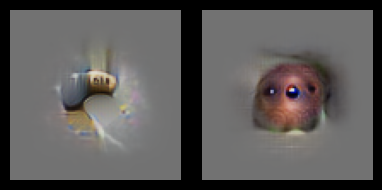

In [4]:
poles = []
for image, alpha in zip(images, alphas):
    pole = blend(image, alpha, imagecut=0.0, alphacut=90.0, boost=1.0)
    poles.append(pole)

plot_group(poles, cols=2)